# High Performance Computing (part I: OpenMP)

- Parallel computing overview
- OpenMP threading model
- OpenMP directives
- Basic techniques in OpenMP:  
         loop parallelization, 
         parallel sections
         synchronization constructs
- Lab exercises with OpenMP  

<hr>

## Parallel vs Serial computing

- Computational tasks are processed in sequential order, essentially, on one CPU core.   
Doesn't take advantage of the modern multi-core architectures.

![Serial job computing](img/serial.png)

- Computational tasks are processed concurrently on the different CPUs or cores

![Parallel computing](img/parallel.png)

The tasks can be different executable codes, code blocks, loops, subroutines, I/O calls, etc.  
The platform can be a single multi-core host or a computational cluster of network interconnected hosts or combination of both.  
Special programming methods and software are required, for example, OpenMP or MPI.


<hr>

## Parallel computing paradigms: shared memory

- Shared memory: all CPUs or cores have access to the same global memory address space.  
Each CPU has its own L1, L2, and L3 cache, as well as CPU cores.  
Most of the main stream commodity based x86 desk
tops and laptops have CPUs with multiple cores.  
Programming approach: multi-threading with POSIX threads (pthreads) and OpenMP.  
Performance scalability with the number of cores may be low due to CPU-RAM traffic increase, high latency of RAM, and maintaining of the cache coherency.  

![](img/shared_ram.png)

- Programming approach: multi-threading with POSIX threads (pthreads) and OpenMP.

<hr>

## Parallel computing paradigms: distributed memory

- Distributed memory: the CPUs have access only to their own memory space. Data is exchanged via messages passed over the network.  
The network can be various: Ethernet, Infiniband, OmniPath  

![](img/distributed_ram.png)


- Programming approach: Message Passing Interface (MPI)

<hr>

## Parallel computing paradigms: Hardware acceleration

- Hardware acceleration: some tasks are offloaded from CPU onto a multi-core GPU device. Data is transferred over a PCIe bus between the RAM and GPU.  

![](img/hardware_accel.png)

- Programming approach: CUDA, OpenCL, OpenACC. The latest OpenMP, 5.0, supports offloading to accelerator devices.

<hr>

## Parallel code speedup

In practice, usually only a part of a code can be efficiently parallelized.   
Amdahl's law imposes a theoretical limit on a parallel code speedup:

Speedup = ${Wall \; clock  \; time \; of \; serial \; execution}\over{Wall \; clock \; time \; of \; parallel \; execution}$ = $1 \over{S + {{P}\over{N}}}$

Where $S$ is the scalar portion of the work,  
$P$ is the parallel portion of the work,  
and $N$ is the number of CPUs or cores.  
By normalization, $S + P = 1$


For example, if only 50% of a code can be parallelized, its theoretical speedup can't exceed the factor of two, according to the Amdahl's law.

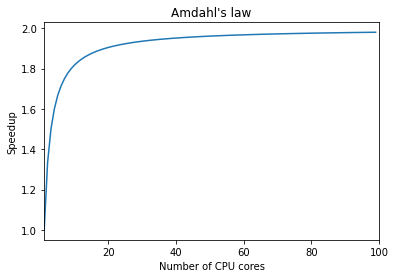

In [20]:
import numpy as np  
import matplotlib.pyplot as plt  
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.xlabel('Number of CPU cores')
    plt.ylabel('Speedup')
    plt.title('Amdahl\'s law')
    plt.xlim(1,100)
    plt.plot(x, y)
    plt.show()
    
graph('1/(0.5 + 0.5/x)', range(1, 100))

As you can see on the graph above, it doesn't make much sense utilizing more than 12 CPU cores for running the code since we may be able to reach about 90% of the maximum theoretical speedup on just 12 cores.

<hr>

## Shared memory systems and OpenMP

- All modern desktops and laptops have multi-core CPUs with access to a common memory address space, so considered shared memory architectures.
- You can use OpenMP if you program in C, C++, Fortran 77 or 90.
- OpenMP extension is available in many modern compilers, for example GNU, Intel, PGI, Visual C++.
- No need for a computational cluster.
- Many commercial and open source software packages are already built with OpenMP and can take advantage of multiple CPU cores.
- Can be easily applied to parallelize loops and sections in a serial code.
- Scalability is limited by the number of CPU cores in a system.

<hr>

## What is OpenMP

- OpenMP is an API environment for shared memory computer architectures.
- It is implemented in the compilers, C/C++, and Fortran, through compiler directives, runtime libraries routines, and environment variables.
- Thread based parallelism: multiple threads concurrently compute tasks in the same code.
- Fork-join thread dynamics: the master thread forks a team of threads in a parallel region, then the threads terminate upon exiting the parallel region.
- Defined data scoping: shared or private to the threads.

<hr>

## OpenMP workflow schematic

Shared memory is used by parallel threads.  
The master process forks threads in the parallel region of the code.  

![](img/omp_threading1.png)

<hr>

## C/C++ general code structure with OpenMP compiler directives:


```cpp
int main() {
    int    var1, var2;
    float  var3;

    /* Serial code */ 

    /* Beginning of parallel section. Fork a team of threads. Specify variable scoping */

    #pragma omp parallel  private(var1, var2)  shared(var3)
    {
       /* Parallel section executed by all threads */


       /* All threads join master thread and disband */
    }  
/* Resume serial code */ 
}
```

## OpenMP code compilation

Recent gcc and gfortran compilers include OpenMP support.
```bash
gcc -fopenmp testcode.c
export OMP_NUM_THREADS=4
./a.out
```
Usually, `OMP_NUM_THREADS` shouldn't exceed the total number of available cores in a system.  
If `OMP_NUM_THREADS` is undefined, the run will utilize all available cores on the system.

<hr>

## OpenMP compiler directives – pragma, constructs, clauses

`
#pragma omp construct [clause [clause]…]  
`

For example:  

`
#pragma omp parallel  shared(a,b,c)  private(i)  
`

`
#pragma omp sections nowait  
`

`
#pragma omp section  
`

`
#pragma omp for  
`

- The constructs specify what the threads should do, for example:  
Compute concurrently blocks/sections of a code,  `#pragma omp section`   
Compute concurrently distributed chunks of loop iterations,  `#pragma omp for`  
Thread synchronization,   `#pragma omp critical`  
<br>

- The clauses define the parameters for the constructs, for example:  
Variable scope (private for each thread),  `private(i)`  
Variable scope (shared for the threads),  `shared(a,b,c)`  
Scheduling directives, `nowait, schedule`  
Synchronization related directives,   `critical, reduction`  


<hr>


## The runtime library functions

They set and query parameters for the threads, for example  

`omp_get_num_threads` – returns the number of threads in the running team.

`omp_get_thread_num` – returns the thread number  

There are 57 run time library functions in the OpenMP in gcc 7.5:  
```bash
egrep 'omp_.*\(' $(find /usr -name omp.h)
```
<hr>


## Parallel regions (exercise)

Simple "Hello World" program. Every thread executes all code enclosed in the parallel section. OpenMP library routines are used to obtain thread identifiers and total number of threads.

```cpp
#include <omp.h>
#include <stdio.h>
int main ()  {

    int nthreads, tid;
    /* Fork a team of threads with each thread having a private tid variable */
    #pragma omp parallel private(tid)
      {
      /* Obtain and print thread id */
      tid = omp_get_thread_num();
      printf("Hello World from thread = %d\n", tid);

      /* Only master thread does this */
      if (tid == 0)
        {
        nthreads = omp_get_num_threads();
        printf("Number of threads = %d\n", nthreads);
        }  /* All threads join master thread and terminate */
      }
}
```

Copy the content of the code above into file `hello.c`, then compile and run it across 4 threads as follows:
```bash
gcc -fopenmp -o hello.x hello.c
export OMP_NUM_THREADS=4
./hello.x
```

<hr>

## Parallel loops

A simple work sharing construct: parallel loops  

```bash
export OMP_NUM_THREADS=4
```

```cpp
/* Fork a team of threads with private i , tid  variables */
#pragma omp parallel private(i, tid)
{
      same_work();  
// Compute the for loop iteractions in parallel
#pragma omp for 
  for (i=0; i<=4*N-1; i++) 
  { 
      thread(i);  //should be a thread safe function
  }                   //the final results are independent on the order of the 
}                     //loop iteration
```
             
             

![](img/pragma_omp_for.png)

<hr>

## The `for` loop construct

Since the parallel region has been defined, the iterations of the loop must be executed in parallel by the team. 

```cpp
#pragma omp for [clause ...] 
                schedule (type [,chunk])  //how the loop iterations assigned to threads 
                private (list)            //the variable scope private to the threads
                shared (list).            //the variable scope shared to the threads
                reduction (operator: list)  //if reduction is applied to the total value
                collapse (n)                //in case of nested loop parallelization
                nowait       //if set, the threads do not synchronize at the end of the parallel loop
```

There are other possible clauses in the `for` construct not discussed here.

<hr>

## The `for` loop schedule clause

Describes how the iterations of the loop are divided among the threads in the team. 

`STATIC`: loop iterations are divided into pieces of size chunk and then statically assigned to the threads.  
`DYNAMIC`:   the chunks, and dynamically scheduled among the threads; when a thread finishes one chunk, it is dynamically assigned another. The default chunk size is 1.  
`GUIDED`:   similar to DYNAMIC except that the block size decreases each time a parcel of work is given to a thread.  
`RUNTIME`:   defined by the environment variable OMP_SCHEDULE  
`AUTO`:   the scheduling decision is delegated to the compiler and/or runtime system.  

<hr>

## The `for` loop (exercise)

The loop iterations computed concurrently.

```cpp
#include <stdio.h>
#include <omp.h>

#define CHUNKSIZE 100
#define N     1000

int main ()
{

    int i, chunk, tid;
    float a[N], b[N], c[N];

    /* Some initializations */
    for (i=0; i < N; i++)
      a[i] = b[i] = i * 1.0;
    chunk = CHUNKSIZE;

    #pragma omp parallel shared(a,b,c,chunk) private(i) 
    #pragma omp for schedule(dynamic,chunk) nowait
      for (i=0; i < N; i++)
       {
         c[i] = a[i] + b[i];

          /* Obtain and print thread id and array index number */
         tid = omp_get_thread_num();
         printf("thread = %d, i = %d\n", tid, i);

       }  /* end of parallel section */
}
```

Copy the content of the code above into file `for.c`, then compile and run it as follows:
```bash
gcc -fopenmp -o for.x for.c
export OMP_NUM_THREADS=4
./for.x
```
Run `./for.x` several times and observe how the array elements are distributed across the threads.


## Nested loops

By default only the outer loop is parallelized:

```cpp
#pragma omp parallel for
    for (int i=0;i<N;i++)
    { 
      for (int j=0;j<M;j++)
      {
       /* do task(i,j) */
      }
    }
```

To parallelize both the loops:
```cpp
#pragma omp parallel for collapse(2) 
    for (int i=0;i<N;i++)
    { 
      for (int j=0;j<M;j++)
      {
       /* do task(i,j) */
      }
}
```

<hr>

## Parallel sections (exercise)

Independent SECTION directives are nested within a SECTIONS directive. Each SECTION is executed once by a thread in the team. Different sections may be executed by different threads. It is possible that for a thread to execute more than one section if it is quick enough and the implementation permits such.

```cpp
#include <omp.h>
#include <stdio.h>

#define N     1000

int main ()
    { int i, tid;
    float a[N], b[N], c[N], d[N];

    /* Some initializations */
    for (i=0; i < N; i++) {
          a[i] = i * 1.5;
          b[i] = i + 22.35;
    }

    #pragma omp parallel shared(a,b,c,d) private(i)
      {

      #pragma omp sections nowait
       {

        #pragma omp section
        {
        for (i=0; i < N; i++)
          c[i] = a[i] + b[i];
          /* Obtain and print thread id and array index number */
          tid = omp_get_thread_num();
          printf("thread = %d, i = %d\n", tid, i);
        }

        #pragma omp section
        {
        for (i=0; i < N; i++)
          d[i] = a[i] * b[i];
          /* Obtain and print thread id and array index number */
          tid = omp_get_thread_num();
          printf("thread = %d, i = %d\n", tid, i);
        }
       }  /* end of sections */
      }  /* end of parallel section */
}
```

Copy the content of the code above into file sections.c, then compile and run it as follows:
```bash
gcc -fopenmp -o sections.x sections.c
export OMP_NUM_THREADS=2
./sections.x
```
Run `./sections.x` several times and observe how the code sections are distributed across the threads.

<hr>

## When things become messy

Several threads are updating the same variable.

```cpp 
#pragma omp parallel for shared (sum) private (i) 
    for ( int i=0; i < 1000000; i++) {
           sum = sum + a[i];
        }
    printf("sum=%lf\n",sum);
```

The threads overwrite the sum variable for each other, running into the “race condition”.  
The problem can be solved by using critical locks and critical sections, when only one thread at a time updates the sum.

<hr>

## Synchronization construct

```cpp
#pragma omp parallel for shared (sum) private (i) 
        for ( int i=0; i < 1000000; i++) {
         #pragma omp critical
           sum = sum + a[i];
        }
      printf("sum=%lf\n",sum);
```
The `critical` section specifies a region of a code that must be executed by only one thread at a time. 

<hr>

## Syncronization construct (exercise)

Create a new directory for exercises. Download a tar ball into the directory. Extract the files:

```bash
mkdir OpenMP
cd OpenMP
wget  https://linuxcourse.rutgers.edu/lessons/HPC_1/OpenMP.tgz
tar –zxvf OpenMP.tgz
```

Compile sum.c with the -fopenmp and run executable across 2 threads:
```bash
export  OMP_NUM_THREADS=2
gcc   -fopenmp   -o sum.x  sum.c
./sum.x
```

Modify file `sum.c` and remove the line with the construct `critical`. Recompile it again and run several times. Notice the different output results.

<hr>

## Reduction clause

Scalar product of two vectors, $\vec{A}$ and $\vec{B}$:  


result = $(\vec{A} \cdot \vec{B})$ = $A_0 \cdot B_0 + A_1 \cdot B_1 + … + A_{n-1} \cdot B_{n-1} $  

Have each thread to compute partial sums, `result`,  on a chunk of data.

```cpp
#pragma omp parallel for      \
      default(shared) private(i)  \
      schedule(static,chunk)      \
      reduction(+:result)

      for (i=0; i < n; i++)
        result = result + (a[i] * b[i]);    
```
A private copy for variable `result` is created for each thread. At the end of the reduction, the reduction variable is written in the global shared variable.

<hr>

## Reduction clause (exercise)

In directory OpenMP compile `reduction.c` and execute in 4 threads:
```bash
gcc -fopenmp -o reduction.x reduction.c
export OMP_NUM_THREADS=4
./reduction.x
```

<hr>

## CPU core number and performance (exercise)

Find out the number of CPU cores available on your desktop:
```bash
grep processor /proc/cpuinfo
```
In the output, you should see 'processor : 0', ... 'processor : 7', which means there are eight CPU threads available, and you can utilize them for running two OpenMP threads concurrently.
Alternatively, you can run command `lscpu`
```bash
lscpu
```
Download a source file with a C code for solving the steady state heat equation on a rectangular region:
```bash
wget http://linuxcourse.rutgers.edu/lessons/HPC_1/heated_plate_openmp.c
```
Compile the source code with OpenMP:
```bash
gcc -fopenmp -o heated_plate.x heated_plate_openmp.c -lm
```
Run the compiled executable, `heated_plate.x`, with one thread:
```bash
export OMP_NUM_THREADS=1
./heated_plate.x > heated_plate_local_gcc_output.txt
```
While the application is running, open another console terminal and run command top. It shows the CPU and RAM utilization, as well as the most resource consuming processes. Type "1" to see the utilization of all the CPU cores. Type "H" to see all the process threads.  

Run it with 2 threads:
```bash
export OMP_NUM_THREADS=2
./heated_plate.x >> heated_plate_local_gcc_output.txt
```
Run it with 4 threads:
```bash
export OMP_NUM_THREADS=4
./heated_plate.x >> heated_plate_local_gcc_output.txt
```
Repeat runs for cases OMP_NUM_THREADS=6, 8, 10.

The output results in the six runs above have been written in file `heated_plate_local_gcc_output.txt`
Compare the run time (Wallclock time) in the above cases:
```bash
grep Wallclock heated_plate_local_gcc_output.txt
```
Notice that the shortest Wallclock time was achieved in the 4 thread run , about 12.3 sec, almost three times faster than in the serial case, one core run. The CPUs on the virtual desktops have 4 physical cores. 
In case of the 8, 10 and 16 threads, the run took longer due to a slight overhead caused by the thread competition for the two CPU cores.


## References


[LLNL Introduction to Parallel Computing](https://computing.llnl.gov/tutorials/parallel_comp/)  

[LLNL OpenMP tutorial](https://computing.llnl.gov/tutorials/openMP/)  

[LinuxPRO magazine 9/2008: Parallel Programming with OpenMP](http://www.linuxpromagazine.com/Issues/2008/94/OpenMP/%28kategorie%29/0)  
